In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import toynet
from evolutions import *
from utils import stack_imgs, dotdict
from evaluation import solve_ode
from train_utils import AdaptiveLoss

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## Define evolution

SIMPLE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0\sqrt{1-t},t\mathbf{I})\bigg)$$
VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})\bigg)$$
sub-VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})^2\bigg)$$

In [13]:
device = torch.device('cuda')

config = dotdict()
config.model = dotdict()
config.model.evolution = 'vpsde'
config.model.task = 'diffusion'
config.model.s = 'generic'
config.model.classification = False
config.data = dotdict()
config.data.ydim = 0

q_t, alpha, sigma, w, dwdt = get_q(config)

data_samples = 2000
data = torch.randn([data_samples,1]) + 2
data = torch.vstack([data, torch.randn([data_samples,1]) - 2])
data = data/data.std()
data = data.to(device)

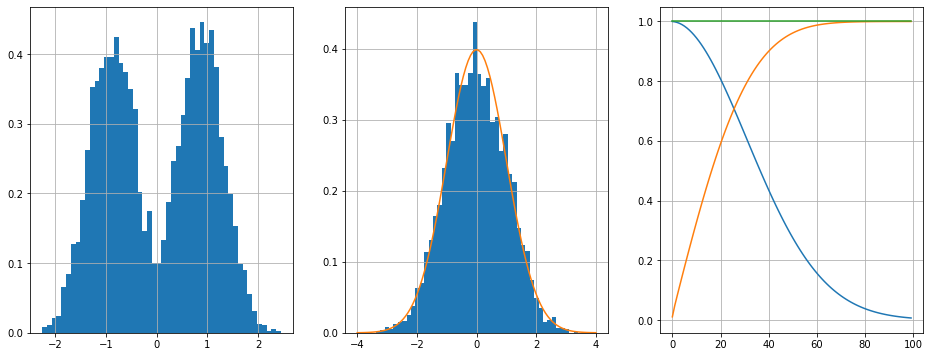

In [14]:
figsize(16,6)
plt.subplot(131)
plt.hist(data.cpu().numpy(), bins=50, density=True)
plt.grid()

x_1 = q_t(data, torch.ones([data.shape[0],1]).to(device))
plt.subplot(132)
plt.hist(x_1.cpu().numpy(), bins=50, density=True)
x = np.linspace(-4,4,100)
plt.plot(x, np.exp(-0.5*x**2)/math.sqrt(2*math.pi))
plt.grid()

plt.subplot(133)
eps = 1e-3
plt.plot(alpha(torch.linspace(eps,1-eps,100)))
plt.plot(sigma(torch.linspace(eps,1-eps,100)))
plt.plot(alpha(torch.linspace(eps,1-eps,100))**2 + sigma(torch.linspace(eps,1-eps,100))**2)
plt.grid()

## Learning the potential

$$\int dx\;dt\;q_t\omega_t\bigg[\frac{1}{2}\Vert\nabla s\Vert^2 + \frac{\partial s}{\partial t}\bigg] + \int dx\;dt\; q_ts\frac{\partial \omega_t}{\partial t} - \int dx\;\bigg[ q_1\omega_1s_1 - q_0\omega_0s_0\bigg] \to \min_s$$

In [31]:
net = toynet.SmallMLP().to(device)
s = lambda t,x: net(t,x)
loss_AM = AdaptiveLoss(alpha=1.0)

In [32]:
torch.manual_seed(1)

optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.9, .999))
n_iter = 20000
n_samples = 512
losses = np.zeros(n_iter)
for i in range(n_iter):
    for p in net.parameters(): p.grad = None
    
    x = data[torch.randperm(data.shape[0])[:n_samples]]
    loss, stats = loss_AM.get_loss(s, x, q_t, w, dwdt)
    loss.backward()
    optimizer.step()
    losses[i] = loss.detach().cpu().numpy()
    if (i % 2000) == 0:
        print('iteration: %d, loss: %.3e' % (i,losses[i]))

iteration: 0, loss: 1.776e-01
iteration: 2000, loss: -2.465e-02
iteration: 4000, loss: 5.703e-03
iteration: 6000, loss: -1.866e-03
iteration: 8000, loss: -3.539e-02
iteration: 10000, loss: 8.795e-04
iteration: 12000, loss: 4.859e-03
iteration: 14000, loss: -3.315e-02
iteration: 16000, loss: -1.243e-02
iteration: 18000, loss: -4.246e-03


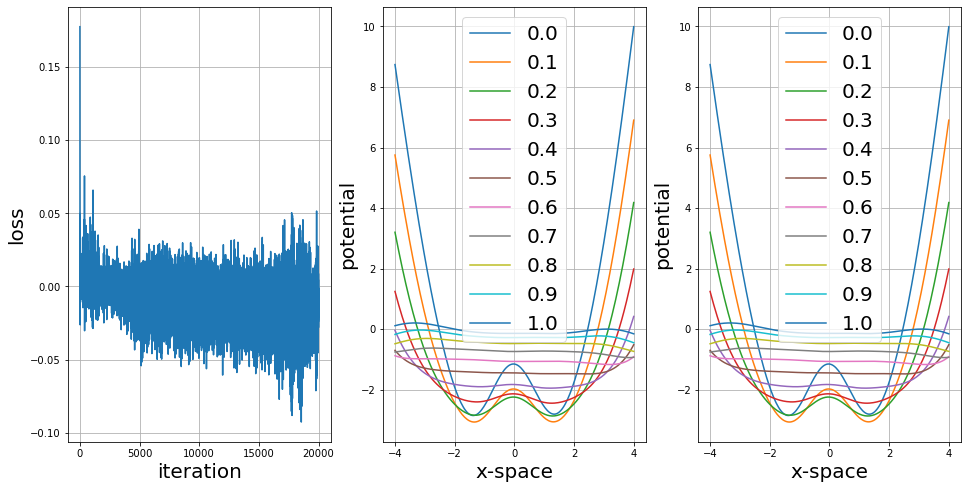

In [33]:
fs = 20

figsize(16,8)
plt.subplot(131)
plt.plot(losses)
# plt.ylim(-0.2,0.1)
plt.xlabel('iteration', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.grid()
plt.subplot(132)
n_points = 200
for i in range(11):
    x = torch.linspace(-4,4,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), s(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()
plt.subplot(133)
n_points = 200
for i in range(11):
    x = torch.linspace(-4,4,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), net(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()

In [34]:
times = torch.linspace(0,1,100).to(device)
kinetic = torch.zeros_like(times).cpu()
time_der = torch.zeros_like(times).cpu()
for i,t in enumerate(times):
    x_t = q_t(data[:500], t)
    vec_t = t*torch.ones_like(x_t)
    x_t.requires_grad, vec_t.requires_grad = True, True
    dsdx, dsdt = torch.autograd.grad(s(vec_t, x_t).sum(), [x_t, vec_t])
    dsdx, dsdt = dsdx.detach(), dsdt.detach()
    kinetic[i] = 0.5*(dsdx**2).sum(1).mean().cpu()
    time_der[i] = torch.abs(0.5*(dsdx**2).sum(1) + dsdt.sum(1)).mean().cpu()

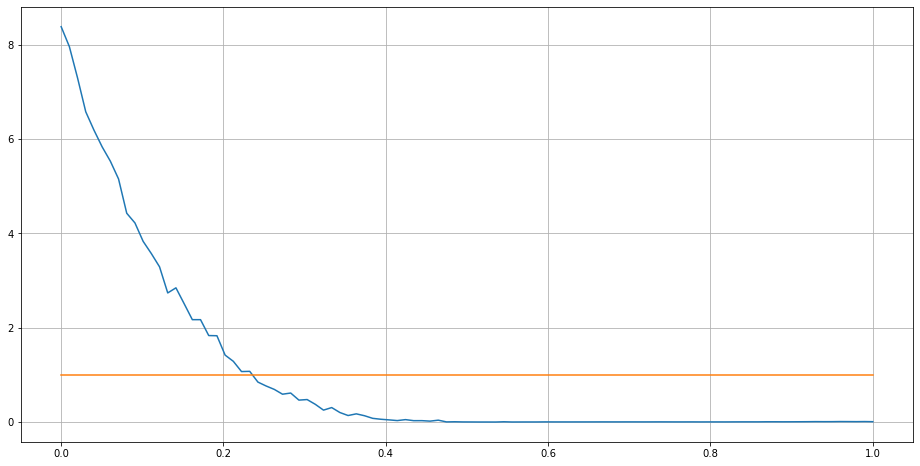

In [35]:
plt.plot(times.cpu(), kinetic/kinetic.mean())
plt.plot(times.cpu(), loss_AM.fp(times.cpu()))
plt.grid()

## Generation

In [26]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
x_0, nfe = solve_ode(device, s, x_1)

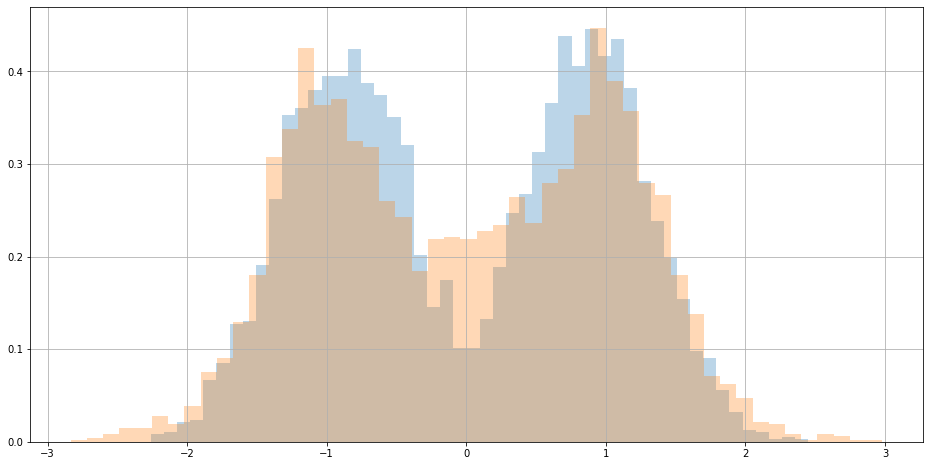

In [27]:
plt.hist(data.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.hist(x_0.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.grid()

## GIF

In [14]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

In [27]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    plt.subplot(121)
    plt.hist(x_t.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label=r'$q_{%.3f}$' % t)
    plt.hist(data.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label='target')
    plt.xlim(-3,3)
    plt.ylim(0.0,0.5)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()

    plt.subplot(122)
    x_plot = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t_plot = t*torch.ones([n_points, 1]).to(device)
    plt.plot(x_plot.cpu().numpy(), s(t_plot,x_plot).detach().cpu().numpy(), 
             label='%.3f' % t)
    plt.plot()
    plt.ylim(4,9)
    plt.xlim(-3,3)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()
    plt.savefig('gifs/simple/%.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [28]:
!convert -delay 10 -loop 0 ./gifs/simple/*.png ./gifs/simple.gif